In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import scipy.signal
from scipy.io.wavfile import read

In [2]:
#dataFilePath = 'RAW_DATA_000001_000002'
#dataFilePath = 'RAW_DATA_000020_000001'
#dataFilePath = 'RAW_DATA_000024_000001'
dataFilePath = 'RAW_DATA_000003_000001'
samplingFrequency = 1.5e6
centerFrequency = 173.5e6

In [3]:
import os
nSamples = int(os.path.getsize(dataFilePath) / 4)
signal = np.zeros(nSamples, dtype=np.complex64)
with open(dataFilePath, 'rb') as dataFile:
    for i in range(nSamples):
        sampleBytes = dataFile.read(4)
        re, im = struct.unpack("<2h", sampleBytes)
        signal[i] = float(re) / 0x7fff + float(im) * 1j / 0x7fff
t = np.arange(0, nSamples / samplingFrequency, 1/samplingFrequency)

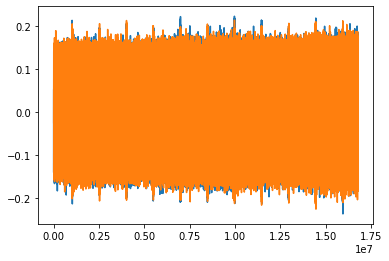

In [4]:
%matplotlib inline
plt.plot(np.imag(signal))
plt.plot(np.real(signal))

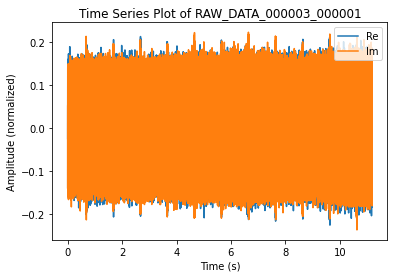

In [5]:
plt.plot(t, np.real(signal), label='Re')
plt.plot(t, np.imag(signal), label='Im')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalized)')
plt.title('Time Series Plot of %s' % (dataFilePath))
plt.legend(loc='upper right')

In [6]:
#nFFTs = 2048 # The original one we had
nFFTs = 8192

if signal.shape[0]%nFFTs != 0:
    signal = signal[signal.shape[0]%nFFTs:] 
    # Occurs so that our data is divisible by nFFTs, otherwise it breaks
    
fft_in = np.reshape(signal, (int(len(signal) / nFFTs), nFFTs))
fft_out = np.fft.fftshift(np.fft.fft(fft_in, norm=None))
fft_freqs = np.fft.fftshift(np.fft.fftfreq(nFFTs, 1/samplingFrequency))
fft_times = np.arange(0, len(signal) / samplingFrequency, nFFTs/samplingFrequency)
spectralPower = np.abs(20 * np.log10(fft_out)) # Calculates PSD

<IPython.core.display.Javascript object>


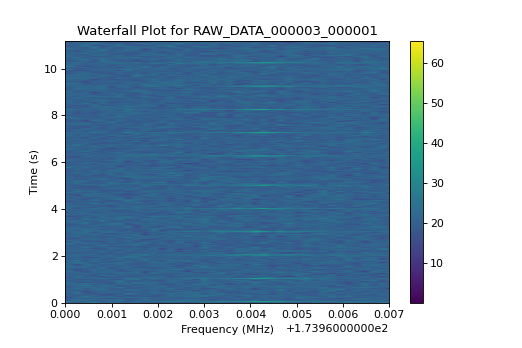

In [20]:
%matplotlib notebook
plt.imshow(spectralPower, origin='lower', extent=((fft_freqs[0] + centerFrequency) / 1e6, (fft_freqs[-1] + centerFrequency) / 1e6, fft_times[0], fft_times[-1]), aspect='auto')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time (s)')
plt.xlim(173.96, 173.967)
plt.title('Waterfall Plot for %s' % (dataFilePath))
plt.colorbar()

In [9]:
import datetime # Used to test how fast code runs
from scipy.stats import kurtosis, skew
import random 

In [10]:
skew_freqs = []
for i in range(spectralPower.shape[1]): 
    skew_freqs.append(skew(spectralPower[:,i]))

found_ping = np.argmax(skew_freqs)
our_freq = (fft_freqs[found_ping] + centerFrequency) / 1e6
print('Our ping frequency is: {}'.format(our_freq))

Our ping frequency is: 173.96435546875


# Calculating Skew
<img src = 'Photos/Calculate Skew.jpg' style='width:516px;height:409px'/>

# Skew Distributions
<img src = 'Photos/Skew Distributions.jpg' style='width:1039px;height:396px'/>


Skew of 173.9644 MHz: 1.078
Skew of 173.6727 MHz: -0.224


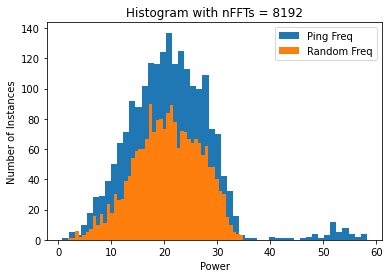

In [11]:
%matplotlib inline
count, bins, ignored = plt.hist(spectralPower[:,found_ping], 50, density=False,label='Ping Freq')
plt.xlabel('Power')
plt.ylabel('Number of Instances')
plt.title('Histogram with nFFTs = {}'.format(nFFTs))
print('Skew of {:.4f} MHz: {:.3f}'.format(our_freq,skew_freqs[found_ping]))


random_freq = random.randint(0,len(skew_freqs)) 
count, bins, ignored = plt.hist(spectralPower[:,random_freq], 50, density=False,label='Random Freq')
plt.legend(loc='upper right')
print('Skew of {:.4f} MHz: {:.3f}'.format((fft_freqs[random_freq] + centerFrequency) / 1e6,skew_freqs[random_freq]))

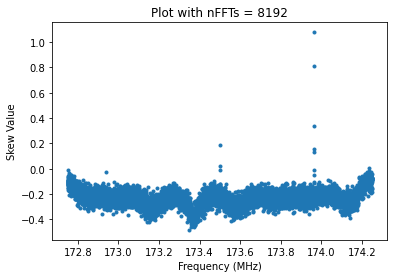

In [13]:
actual_freqs = (fft_freqs + centerFrequency) / 1e6
%matplotlib inline
plt.plot(actual_freqs,skew_freqs,'.')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Skew Value')
#plt.xlim(173.96, 173.967)
#plt.xlim(173.964, 173.965)
#plt.xlim(173.9642, 173.9646)
plt.title('Plot with nFFTs = {}'.format(nFFTs))
plt.savefig("Frequency vs Skew for %s" % (dataFilePath))

In [14]:
temp_list = skew_freqs
temp_list = sorted(temp_list,reverse=True)
top_skews = []
for i in range(20):
    top_skews.append(skew_freqs.index(temp_list[i]))

# Calculating Kurtosis
<img src = 'Photos/Calculate Kurtosis.png' style='width:748px;height:320px'/>

# Kurtosis Distributions
<img src = 'Photos/Kurtosis Distributions.png' style='width:415px;height:234px'/>

In [15]:
kurtosis_freqs = []
for i in range(spectralPower.shape[1]): 
    kurtosis_freqs.append(kurtosis(spectralPower[:,i]))

found_ping = np.argmax(kurtosis_freqs)
our_freq = (fft_freqs[found_ping] + centerFrequency) / 1e6
print('Our ping frequency is: {}'.format(our_freq))

Our ping frequency is: 173.96435546875


Text(0.5, 1.0, 'Plot with nFFTs = 8192')

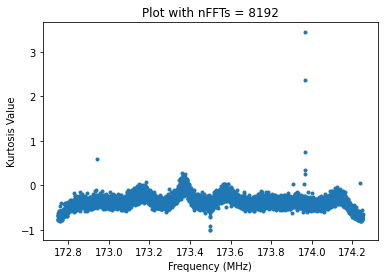

In [16]:
%matplotlib inline
plt.plot(actual_freqs,kurtosis_freqs,'.')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Kurtosis Value')
#plt.xlim(173.96, 173.967)
#plt.xlim(173.964, 173.965)
#plt.xlim(173.9642, 173.9646)
#plt.ylim(4, 10)
plt.title('Plot with nFFTs = {}'.format(nFFTs))